In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


## Model training
### Tree based models
* XGB, LGBM, RF, ETC, DT

### Neural Networks
* NN, autoencoders(?), GNN


## Model Evaluation

### Get Shap for model explanability both local and global
* Tune model on best model selected (either on precision/f1/recall and feature blend)

### Test model on out of sample set
* Get metrics(acc,precision,f1, etc..) from out of sample set

## Selection of Best Model

### Dashboard(?) --enhancement
* Transfer results to a dashboard

# Import file here

In [3]:
# Load Data
#df = pd.read_csv("twitter_human_bots_dataset.csv")
df = pd.read_csv("source data/twitter_human_bots_dataset.csv", index_col=0)



In [4]:

# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Calculate Account Age
current_time = datetime.now()
df['account_age_days'] = (current_time - df['created_at']).dt.days

# Time-Based Features
df['creation_hour'] = df['created_at'].dt.hour
df['creation_day_of_week'] = df['created_at'].dt.dayofweek
df['creation_month'] = df['created_at'].dt.month
df['creation_year'] = df['created_at'].dt.year
df['creation_quarter'] = df['created_at'].dt.quarter
df['is_weekend'] = df['creation_day_of_week'] >= 5
df['creation_week_of_year'] = df['created_at'].dt.isocalendar().week
df['is_beginning_of_month'] = df['created_at'].dt.day <= 5
df['is_end_of_month'] = df['created_at'].dt.day >= 26

# Define part of day based on hour
def part_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['creation_hour'].apply(part_of_day)

# Additional Features
humans_mean = df[df['account_type'] == 'human']['average_tweets_per_day'].mean()
humans_std = df[df['account_type'] == 'human']['average_tweets_per_day'].std()
df['deviation_from_humans'] = (df['average_tweets_per_day'] - humans_mean) / humans_std

# Description Length Feature
df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# Followers/Friends Ratios
df['followers_to_friends_ratio'] = df['followers_count'] / df['friends_count']
df['followers_to_friends_ratio'].fillna(0, inplace=True)

# Followers to Tweets Per Day Ratio
df['followers_to_tweets_per_day_ratio'] = df['followers_count'] / df['average_tweets_per_day']
df['followers_to_tweets_per_day_ratio'].fillna(0, inplace=True)

# Mentions Count in Description
import re

def extract_mentions(description):
    return re.findall(r'@\w+', str(description))

df['mentions'] = df['description'].apply(extract_mentions)
df['mention_count'] = df['mentions'].apply(len)

# Ensure any remaining NaN values are filled if necessary
########################################################################
# TO DISCUSS METHOD OF IMPUTATION
########################################################################
df.fillna(0, inplace=True)
df.replace(np.inf,0, inplace = True)

# ENCODING METHOD FOR LANG AND LOCATION TO BE DISCUSSSED

In [5]:
# Encoding Categorical Features
df['account_type'] = df['account_type'].map({'human': 0, 'bot': 1})

encode_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'lang', 'location', 'verified',
               'creation_year', 'is_weekend', 'is_beginning_of_month', 'is_end_of_month', 'part_of_day']

label_encoder = LabelEncoder()
for col in encode_cols:
    df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string to handle NaNs if any


# Define Feature Columns and Target
id_col = ['id']
labels = ['account_type']
predictive_cols = ['default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count',
                   'geo_enabled', 'lang', 'location', 'statuses_count', 'verified', 'average_tweets_per_day', 
                   'account_age_days', 'creation_hour', 'creation_day_of_week', 'creation_month', 'creation_year',
                   'creation_quarter', 'is_weekend', 'creation_week_of_year', 'is_beginning_of_month', 
                   'is_end_of_month', 'part_of_day', 'deviation_from_humans', 'description_length', 
                   'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio', 'mention_count','account_type']



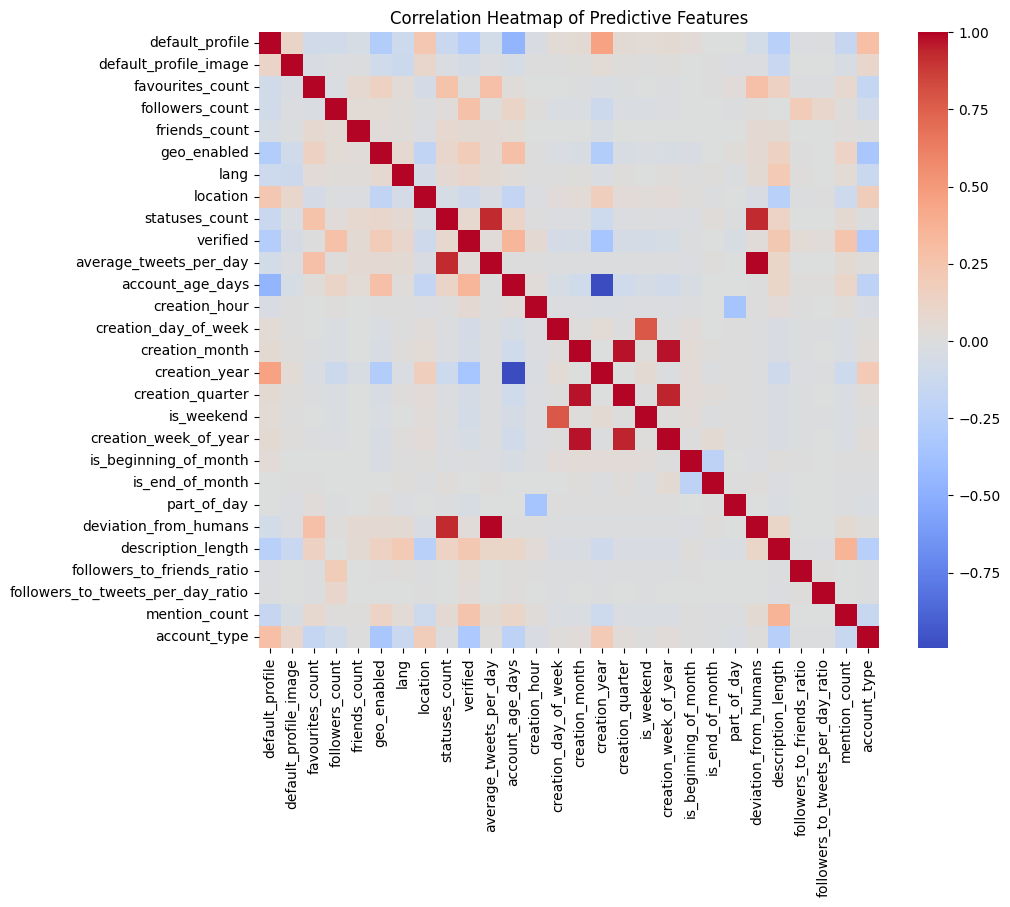


Target Distribution:
account_type
0    25013
1    12425
Name: count, dtype: int64

Target Distribution (%):
account_type
0    66.811796
1    33.188204
Name: proportion, dtype: float64

Data Sample:
           id  default_profile  default_profile_image  favourites_count  \
0  2878719694                0                      0              1307   
1   171600936                1                      0              2204   
2    41269095                0                      0                18   
3   103981160                1                      0              2818   
4    24912175                0                      0              1694   

   followers_count  friends_count  geo_enabled  lang  location  \
0              133            167            0    10      6243   
1               68            621            0    33      3012   
2          1865884              3            1    10      4963   
3            98674            464            0    15      6848   
4             1249  

In [6]:
# Set cutoff date for training/validation split
cutoff_date = pd.to_datetime('2017-01-01')
df['date'] = pd.to_datetime(df['created_at'])

# Define columns to keep
id_cols = ['id']
target_cols = ['account_type']
# Assuming predictive_cols is already defined
columns_to_keep = id_cols + predictive_cols

# Filter columns before splitting
df_filtered = df[columns_to_keep + ['date']]

# Split data based on cutoff date
oot = df_filtered[df_filtered['date'] >= cutoff_date].set_index('id')
df_model = df_filtered[df_filtered['date'] < cutoff_date].set_index('id')

# Drop date column as it's no longer needed
oot = oot.drop('date', axis=1)
df_model = df_model.drop('date', axis=1)

# Train, Test, Validation Splits
RANDOM_SEED = 2024
train, test = train_test_split(df_model, test_size=0.2, random_state=RANDOM_SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=RANDOM_SEED)

# Add 'X_fold' columns for each split
train['X_fold'] = 'train'
test['X_fold'] = 'test'
valid['X_fold'] = 'valid'
oot['X_fold'] = 'oot'

# Combine all datasets for modeling
mds = pd.concat([train, test, valid, oot]).copy(deep=True)
mds = mds.reset_index()

In [7]:
import itertools
import math
from hyperopt import hp
import xgboost as xgb
import lightgbm as lgb
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
from sklearn.model_selection import train_test_split
import warnings



import os

# Supervised Models Pipeline
- Random Forest
- XGBoost
- LGBM
- Logistic Regression

In [119]:
import lightgbm as lgb
import xgboost as xgb
from xgboost import DMatrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import KFold, TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import json
from functools import partial
import warnings
warnings.filterwarnings("ignore")

class UnifiedModelTrainer:
    def __init__(self, random_state=2024):
        self.random_state = random_state
    
    ######################
    ## Data Preparation ##
    ######################
    
    def prepare_data(self, df, features, target):
        """Prepare train, validation, test and out-of-time datasets"""
        train_valid = df[df['X_fold'].isin(['train', 'valid'])]
        test = df[df['X_fold'] == 'test']
        oot = df[df['X_fold'] == 'oot']
        
        X_train_valid = train_valid[features]
        y_train_valid = train_valid[target]
        
        X_test = test[features]
        y_test = test[target]
        
        X_oot = oot[features]
        y_oot = oot[target]
        
        return (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot)

    ##############################
    ## Evaluation Model Metrics ##
    ##############################
    def evaluate_model(self, model, X_test, y_test, X_oot, y_oot):
        """Evaluate model performance on test and OOT datasets"""
        if isinstance(model, lgb.Booster) or isinstance(model, RandomForestClassifier):
            pred_test = model.predict(X_test)
            pred_oot = model.predict(X_oot)
    
        else:
            pred_test = model.predict_proba(X_test)[:, 1]
            pred_oot = model.predict_proba(X_oot)[:, 1]
        
        metrics = {}
        metrics['test_auc'] = roc_auc_score(y_test, pred_test)
        metrics['oot_auc'] = roc_auc_score(y_oot, pred_oot)
        #metrics['recall'] = recall_score(y_test, pred_test)
        
        # Calculate additional metrics for different thresholds
        threshold_metrics = {}
        for threshold in [0.5, 0.8, 0.85, 0.9, 0.95]:
            pred_test_binary = (pred_test > threshold).astype(int)
            pred_oot_binary = (pred_oot > threshold).astype(int)
            
            threshold_metrics[f'threshold_{threshold}'] = {
                'test': {
                    'precision': precision_score(y_test, pred_test_binary),
                    'recall': recall_score(y_test, pred_test_binary),
                    'f1': f1_score(y_test, pred_test_binary),
                    'auc': roc_auc_score(y_test, pred_test_binary)
                },
                'oot': {
                    'precision': precision_score(y_oot, pred_oot_binary),
                    'recall': recall_score(y_oot, pred_oot_binary),
                    'f1': f1_score(y_oot, pred_oot_binary),
                    'auc': roc_auc_score(y_oot, pred_oot_binary)

                }
            }
        
        metrics['threshold_metrics'] = threshold_metrics
        return metrics
        
    ############################
    ## Hyperparameter Tunning ##
    ############################
    def create_search_space(self, model_type):
        """Define complete search space including data preparation and model parameters."""
        
        # Common parameters
        common_params = {
            'k_folds': hp.choice('k_folds', [3, 5, 7, 10]),
            'k_split': hp.choice('k_split', ['non_ts', 'ts']),
            
            # Feature selection parameters
            'f_method': hp.choice('f_method', [
                'all',  # Use all features
                'kbest_f',  # SelectKBest with f_classif
                'kbest_mi',  # SelectKBest with mutual_info_classif
                'l1',  # L1-based feature selection
                'tree_importance'  # Tree-based feature importance
            ]),
            'num_feats': hp.choice('num_feats', [20, 30, 40, 50, 'all']),
            
            # Scaling parameters
            'scaler': hp.choice('scaler', [
                'noscaler',
                'standard',
                'minmax',
                'robust'
            ]),
            
            # Fixed parameters
            'SEED': self.random_state
        }
        
        if model_type == 'lgbm':
            # LightGBM specific parameters
            lgbm_params = {
                'num_leaves': hp.quniform('num_leaves', 15, 127, 1),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
                'feature_fraction': hp.uniform('feature_fraction', 0.6, 0.9),
                'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 0.9),
                'bagging_freq': hp.quniform('bagging_freq', 2, 10, 1),
                'min_child_samples': hp.quniform('min_child_samples', 10, 150, 1),
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50)
            }
            return {**common_params, **lgbm_params}

        elif model_type == 'xgb':
            # XGBoost specific parameters
            xgb_params = {
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
                'subsample': hp.uniform('subsample', 0.6, 1.0),
                'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
                'min_child_weight': hp.quniform('min_child_weight', 1, 7, 1),
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50)
            }
            return {**common_params, **xgb_params}
        
        elif model_type == 'rf':
            rf_params = {
                'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
                'max_depth': hp.quniform('max_depth', 3, 12, 1),
                'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
            }
            return {**common_params, **rf_params}
        
        else:
            raise ValueError("Invalid model type. Please choose 'lgbm' or 'xgb'.")

    
    def apply_feature_selection(self, X, y, method, num_feats):
        """Apply feature selection based on specified method"""
        if method == 'all' or num_feats == 'all':
            return X
            
        n_features = min(num_feats, X.shape[1])
        
        if method == 'kbest_f':
            selector = SelectKBest(score_func=f_classif, k=n_features)
        elif method == 'kbest_mi':
            selector = SelectKBest(score_func=mutual_info_classif, k=n_features)
        elif method == 'l1':
            from sklearn.linear_model import LogisticRegression
            selector = LogisticRegression(penalty='l1', solver='saga', random_state=self.random_state)
            selector.fit(X, y)
            mask = np.abs(selector.coef_[0]) > 0
            return X.iloc[:, mask]
        elif method == 'tree_importance':
            model = lgb.LGBMClassifier(random_state=self.random_state)
            model.fit(X, y)
            importance = pd.Series(model.feature_importances_, index=X.columns)
            selected_features = importance.nlargest(n_features).index
            return X[selected_features]
            
        if method in ['kbest_f', 'kbest_mi']:
            selector.fit(X, y)
            mask = selector.get_support()
            return X.iloc[:, mask]
            
        return X
    
    def plot_results(self, metrics, output_dir):
        """Create and save visualization of results"""
        # Plot threshold performance
        plt.figure(figsize=(12, 6))
        thresholds = sorted(metrics['threshold_metrics'].keys(), 
                          key=lambda x: float(x.split('_')[1]))
        
        test_precision = [metrics['threshold_metrics'][t]['test']['precision'] 
                         for t in thresholds]
        oot_precision = [metrics['threshold_metrics'][t]['oot']['precision'] 
                        for t in thresholds]
        
        plt.plot(thresholds, test_precision, label='Test Precision')
        plt.plot(thresholds, oot_precision, label='OOT Precision')
        plt.xlabel('Threshold')
        plt.ylabel('Precision')
        plt.title('Model Performance Across Thresholds')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/threshold_performance.png")
        plt.close()
    
    def apply_scaling(self, X_train, X_test, X_oot, scaler_type):
        """Apply scaling transformation to the data"""
        if scaler_type == 'noscaler':
            return X_train, X_test, X_oot
            
        if scaler_type == 'standard':
            scaler = StandardScaler()
        elif scaler_type == 'minmax':
            scaler = MinMaxScaler()
        elif scaler_type == 'robust':
            scaler = RobustScaler()
            
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=X_train.columns,
            index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=X_test.columns,
            index=X_test.index
        )
        X_oot_scaled = pd.DataFrame(
            scaler.transform(X_oot),
            columns=X_oot.columns,
            index=X_oot.index
        )
        
        return X_train_scaled, X_test_scaled, X_oot_scaled
    
    def get_cv_splitter(self, k_split, k_folds):
        """Get cross-validation splitter based on specified method"""
        if k_split == 'non_ts':
            return KFold(n_splits=k_folds, shuffle=True, random_state=self.random_state)
        else:
            return TimeSeriesSplit(n_splits=k_folds)

###########################################
## Objective Functions for LGBM, XGB, RF ##
###########################################

    def objective_lgb(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Enhanced objective function for LightGBM optimization"""
        try:
            # Apply feature selection
            X_train_selected = self.apply_feature_selection(
                X_train, y_train, space['f_method'], space['num_feats']
            )
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            
            # Apply scaling
            X_train_processed, X_test_processed, X_oot_processed = self.apply_scaling(
                X_train_selected, X_test_selected, X_oot_selected, space['scaler']
            )
            
            # Create CV splitter
            cv_splitter = self.get_cv_splitter(space['k_split'], int(space['k_folds']))
            
            # Prepare LightGBM parameters
            params = {
                'objective': 'binary',
                'metric': 'auc',#auc
                'boosting_type': 'gbdt',
                'num_leaves': int(space['num_leaves']),
                'learning_rate': space['learning_rate'],
                'feature_fraction': space['feature_fraction'],
                'bagging_fraction': space['bagging_fraction'],
                'bagging_freq': int(space['bagging_freq']),
                'min_child_samples': int(space['min_child_samples']),
                'max_depth': int(space['max_depth']),
                'n_estimators': int(space['n_estimators']),
                'verbose': -1,
                'random_state': space['SEED']
            }
            
            # Cross-validation scores
            cv_scores = []
            for train_idx, valid_idx in cv_splitter.split(X_train_processed):
                X_fold_train = X_train_processed.iloc[train_idx]
                y_fold_train = y_train.iloc[train_idx]
                X_fold_valid = X_train_processed.iloc[valid_idx]
                y_fold_valid = y_train.iloc[valid_idx]
                
                train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
                valid_data = lgb.Dataset(X_fold_valid, label=y_fold_valid, reference=train_data)
                
                model = lgb.train(
                    params,
                    train_data,
                    valid_sets=[valid_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=20)]
                )
                
                pred_valid = model.predict(X_fold_valid)
                cv_scores.append(roc_auc_score(y_fold_valid, pred_valid)) # modify metric here for tuning for other metrics
            
            # Train final model on full training data
            train_data = lgb.Dataset(X_train_processed, label=y_train)
            valid_data = lgb.Dataset(X_test_processed, label=y_test, reference=train_data)
            
            final_model = lgb.train(
                params,
                train_data,
                valid_sets=[valid_data],
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
            )
            
            # Calculate metrics
            metrics = self.evaluate_model(
                final_model, 
                X_test_processed, y_test,
                X_oot_processed, y_oot
            )
            
            metrics['cv_score_mean'] = np.mean(cv_scores)
            metrics['cv_score_std'] = np.std(cv_scores)
            
            return {
                'loss': -metrics['cv_score_mean'],  # Optimize for CV performance
                'status': STATUS_OK,
                'model': final_model,
                'metrics': metrics,
                'params': params,
                'feature_columns': list(X_train_processed.columns)
            }
            
        except Exception as e:
            print(f"Error in objective function: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}
    
    def objective_xgb(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Enhanced objective function for XGBoost optimization"""
        try:
            # Apply feature selection
            X_train_selected = self.apply_feature_selection(
                X_train, y_train, space['f_method'], space['num_feats']
            )
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            
            # Apply scaling
            X_train_processed, X_test_processed, X_oot_processed = self.apply_scaling(
                X_train_selected, X_test_selected, X_oot_selected, space['scaler']
            )
            
            # Create CV splitter
            cv_splitter = self.get_cv_splitter(space['k_split'], int(space['k_folds']))
            
            # Prepare XGBoost parameters
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'max_depth': int(space['max_depth']),
                'learning_rate': space['learning_rate'],
                'subsample': space['subsample'],
                'colsample_bytree': space['colsample_bytree'],
                'min_child_weight': int(space['min_child_weight']),
                'n_estimators': int(space['n_estimators']),
                'random_state': space['SEED']
            }
            
            # Cross-validation scores
            cv_scores = []
            for train_idx, valid_idx in cv_splitter.split(X_train_processed):
                X_fold_train = X_train_processed.iloc[train_idx]
                y_fold_train = y_train.iloc[train_idx]
                X_fold_valid = X_train_processed.iloc[valid_idx]
                y_fold_valid = y_train.iloc[valid_idx]
                
                model = xgb.XGBClassifier(**params)
                model.fit(X_fold_train, y_fold_train, eval_set=[(X_fold_valid, y_fold_valid)], 
                        verbose=False)
                
                pred_valid = model.predict_proba(X_fold_valid)[:, 1]
                cv_scores.append(roc_auc_score(y_fold_valid, pred_valid))
            
            # Train final model on full training data
            model = xgb.XGBClassifier(**params)
            model.fit(X_train_processed, y_train, eval_set=[(X_test_processed, y_test)], 
                     verbose=False)
            
            # Calculate metrics
            metrics = self.evaluate_model(
                model, 
                X_test_processed, y_test,
                X_oot_processed, y_oot
            )
            
            metrics['cv_score_mean'] = np.mean(cv_scores)
            metrics['cv_score_std'] = np.std(cv_scores)
            
            return {
                'loss': -metrics['cv_score_mean'],  # Optimize for CV performance
                'status': STATUS_OK,
                'model': model,
                'metrics': metrics,
                'params': params,
                'feature_columns': list(X_train_processed.columns)
            }
            
        except Exception as e:
            print(f"Error in objective function: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}

    def objective_rf(self, space, X_train, y_train, X_test, y_test, X_oot, y_oot):
        """Objective function for RandomForestClassifier"""
        try:
            # Feature selection and scaling
            X_train_selected = self.apply_feature_selection(X_train, y_train, space['f_method'], space['num_feats'])
            X_test_selected = X_test[X_train_selected.columns]
            X_oot_selected = X_oot[X_train_selected.columns]
            X_train_scaled, X_test_scaled, X_oot_scaled = self.apply_scaling(X_train_selected, X_test_selected, X_oot_selected, space['scaler'])

            # Set parameters for RandomForestClassifier
            params = {
                'n_estimators': int(space['n_estimators']),
                'max_depth': int(space['max_depth']),
                'min_samples_split': int(space['min_samples_split']),
                'min_samples_leaf': int(space['min_samples_leaf']),
                'random_state': self.random_state
            }
            
            model = RandomForestClassifier(**params)
            model.fit(X_train_scaled, y_train)
            metrics = self.evaluate_model(model, X_test_scaled, y_test, X_oot_scaled, y_oot)
            
            return {'loss': -metrics['test_auc'], 
                    'model': model, 
                    'status': STATUS_OK, 
                    'metrics': metrics,
                    'params': params,
                    'feature_columns': list(X_train_selected.columns)}

        except Exception as e:
            print(f"RandomForest Error: {str(e)}")
            return {'loss': 0, 'status': STATUS_OK, 'model': None}
    
    #########################
    ## Logistic Regression ##
    #########################
    def run_logistic_regression(self, df, features, target):

        # Prepare the data using the prepare_data method
        (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot) = self.prepare_data(df, features, target)
        
        # Initialize and fit the logistic regression model
        log_reg = LogisticRegression()
        log_reg.fit(X_train_valid, y_train_valid)
        
        # Make predictions on the test set
        y_pred_prob = log_reg.predict_proba(X_test)[:,1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Calculate accuracy, confusion matrix, and classification report
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        class_report = classification_report(y_test, y_pred)
        
        # Print results
        print(f"Accuracy: {accuracy:.2f}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print("Classification Report:")
        print(class_report)
        
        # Store metrics in a dictionary for further use
        metrics = {
            "accuracy": accuracy,
            "confusion_matrix": conf_matrix,
            "classification_report": class_report
        }
        
        return log_reg, metrics

    def optimize_model(self, df, features, target, max_evals=20, model_type = ""):
        """Run complete model optimization pipeline with enhanced search space"""
        # Prepare data
        (X_train_valid, y_train_valid), (X_test, y_test), (X_oot, y_oot) = self.prepare_data(
            df, features, target
        )
        if model_type == 'lgbm':
        # Define objective function with prepared data
            objective = partial(
                self.objective_lgb,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        if model_type == 'xgb':
            objective = partial(
                self.objective_xgb,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        if model_type == 'rf':
            objective = partial(
                self.objective_rf,
                X_train=X_train_valid,
                y_train=y_train_valid,
                X_test=X_test,
                y_test=y_test,
                X_oot=X_oot,
                y_oot=y_oot
            )
        
        # Run optimization
        trials = Trials()
        best = fmin(
            fn=objective,
            space=self.create_search_space(model_type),
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials
        )
        
        # Get best trial
        best_trial = sorted(trials.trials, key=lambda x: x['result']['loss'])[0]
        
        # Store trials history
        self.trials_history = pd.DataFrame([
            {
                **trial['misc']['vals'],
                'cv_score': -trial['result']['loss'],
                'test_auc': trial['result']['metrics']['test_auc'],
                'oot_auc': trial['result']['metrics']['oot_auc'],
                **{
                    f"threshold_{threshold}_{metric}_{set_type}": trial['result']['metrics']['threshold_metrics'][f'threshold_{threshold}'][set_type][metric]
                    for threshold in [0.5,0.8, 0.85, 0.9, 0.95]
                    for set_type in ['test', 'oot']
                    for metric in ['precision', 'recall', 'f1', 'auc']
                }
            }
            for trial in trials.trials
            if 'loss' in trial['result']
        ])
        
        return (
            
            best_trial['result']['model'],
            best_trial['result']['metrics'],
            best_trial['result']['params'],
            best_trial['result']['feature_columns']
            
         )
    
    
    def save_model(self, model, output_dir, model_type, model_name='_best_model.pkl'):
        """Save the trained XGBoost model to a pickle file."""
        with open(f"{output_dir}/{model_type + model_name}", 'wb') as f:
            pickle.dump(model, f)

    def load_model(self, model_path):
        """Load a trained XGBoost model from a pickle file."""
        with open(model_path, 'rb') as f:
            return pickle.load(f)
        


# Running Models

In [120]:
# Initialize trainer
trainer = UnifiedModelTrainer(random_state=2024)

# Load data
df = mds
features = [col for col in df.columns if col not in ['id', 'account_type', 'X_fold']]
target = 'account_type'

# Run optimization with extended search space
modelrf, metricsrf, paramsrf, selected_featuresrf = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'rf'
)
modelxgb, metricsxgb, paramsxgb, selected_featuresxgb = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'xgb'
)

modellgbm, metricslgbm, paramslgbm, selected_featureslgbm = trainer.optimize_model(
    df, features, target, max_evals=10, model_type = 'lgbm'
)

log_reg, metrics = trainer.run_logistic_regression(df, features, target)



100%|██████████| 10/10 [01:33<00:00,  9.32s/trial, best loss: -0.9380806463608066]
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:                    
[82]	valid_0's auc: 0.93155
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:                    
[67]	valid_0's auc: 0.930955
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:                    
[68]	valid_0's auc: 0.93769
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:                    
[67]	valid_0's auc: 0.939346
Training until validation scores don't improve for 20 rounds                     
Early stopping, best iteration is:                                               
[672]	valid_0's auc: 0.931099
Training until validation scores don't improve for 20 rounds                     
Early stopping, best iteration is:                             

In [122]:
metricsrf
metricsxgb
metricslgbm

{'test_auc': np.float64(0.8346523628367389),
 'oot_auc': np.float64(0.656679747377404),
 'threshold_metrics': {'threshold_0.5': {'test': {'precision': np.float64(0.8523042754025542),
    'recall': np.float64(0.7257683215130024),
    'f1': np.float64(0.7839632277834525),
    'auc': np.float64(0.8346523628367389)},
   'oot': {'precision': np.float64(0.768990634755463),
    'recall': np.float64(0.4473365617433414),
    'f1': np.float64(0.5656333716035209),
    'auc': np.float64(0.656679747377404)}},
  'threshold_0.8': {'test': {'precision': np.float64(0.8523042754025542),
    'recall': np.float64(0.7257683215130024),
    'f1': np.float64(0.7839632277834525),
    'auc': np.float64(0.8346523628367389)},
   'oot': {'precision': np.float64(0.768990634755463),
    'recall': np.float64(0.4473365617433414),
    'f1': np.float64(0.5656333716035209),
    'auc': np.float64(0.656679747377404)}},
  'threshold_0.85': {'test': {'precision': np.float64(0.8523042754025542),
    'recall': np.float64(0.725

# Save Models

In [121]:
trainer.save_model(modelxgb, model_type = 'xgb', output_dir= "output_files")
trainer.save_model(modelrf, model_type = 'rf', output_dir= "output_files")
trainer.save_model(modellgbm, model_type = 'lgbm', output_dir= "output_files")


# Global SHAP EXPLAINABILITY

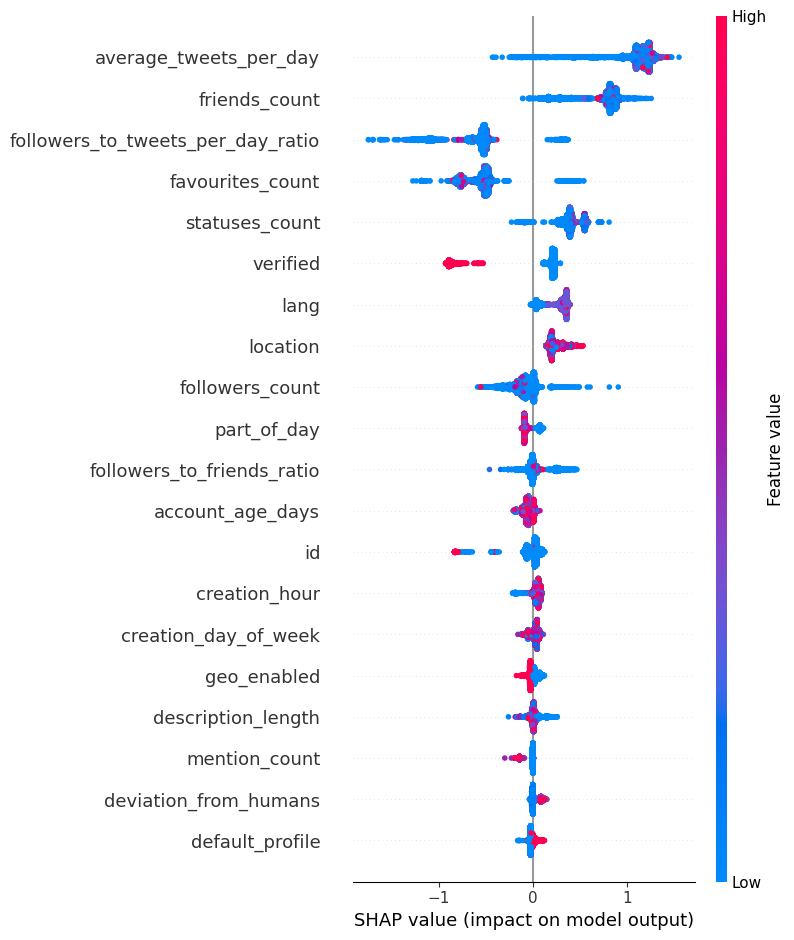

In [171]:
import shap

# Load the model from the pickle file
loaded_model = trainer.load_model('output_files/{0}_best_model.pkl'.format('xgb')) # change model type here

# Assuming you have your data prepared
explainer = shap.Explainer(loaded_model)
test = df[df['X_fold'] == 'test']
X_test = test[features]
y_test = test[target]    
shap_values = explainer(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)


# Local SHAP Explainability

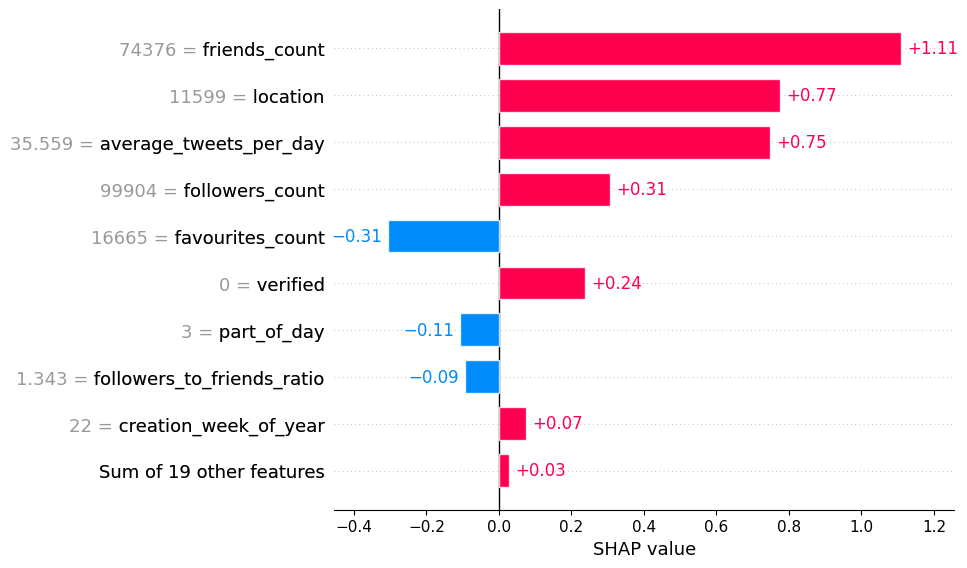

In [87]:
#shap.plots.bar(shap_values)
shap.plots.bar(shap_values[0])


# Auto Encoder

In [96]:
%pip install tensorflow

Python(38179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 239.4 MB 22.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 24.7 MB/s eta 0:00:01
     |████████████████████████████████| 71 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 396 kB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 21.7 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 15.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.0 MB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 414 kB 18.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 19.1 MB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 41.5 MB/s eta 0:00:01
     |████████████████████████████████| 242 kB 14.3 MB/s eta 0:00:01
     |█████████████████

In [97]:
# Import necessary libraries for deep learning
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Filter data for "normal" examples (assuming `account_type` 0 is normal, 1 is anomaly)
normal_data = mds[mds['account_type'] == 0][predictive_cols]
anomalous_data = mds[mds['account_type'] == 1][predictive_cols]

# Scale the data
scaler = StandardScaler()
normal_data_scaled = scaler.fit_transform(normal_data)
anomalous_data_scaled = scaler.transform(anomalous_data)

# Define autoencoder architecture
input_dim = normal_data_scaled.shape[1]  # Number of features
encoding_dim = int(input_dim / 2)  # Define encoding dimension (e.g., half of input)

input_layer = Input(shape=(input_dim,))
# Encoder
encoder = Dense(encoding_dim, activation="relu")(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
# Decoder
decoder = Dense(encoding_dim, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

# Build and compile the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mse")

# Train the autoencoder on normal data
history = autoencoder.fit(
    normal_data_scaled, normal_data_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Calculate reconstruction error on normal and anomalous data
normal_data_reconstructed = autoencoder.predict(normal_data_scaled)
anomalous_data_reconstructed = autoencoder.predict(anomalous_data_scaled)

# Compute Mean Squared Error for each sample
normal_mse = np.mean(np.power(normal_data_scaled - normal_data_reconstructed, 2), axis=1)
anomalous_mse = np.mean(np.power(anomalous_data_scaled - anomalous_data_reconstructed, 2), axis=1)

# Define a threshold based on normal data MSE
threshold = np.percentile(normal_mse, 95)  # 95th percentile as threshold

# Flag anomalies based on reconstruction error
normal_data['anomaly'] = normal_mse > threshold
anomalous_data['anomaly'] = anomalous_mse > threshold

# Check anomaly detection performance
print("Anomalies in normal data (false positives):", normal_data['anomaly'].sum())
print("Anomalies in anomalous data (true positives):", anomalous_data['anomaly'].sum())

# Combine results for confusion matrix and performance metrics
# True labels: 0 for normal (account_type 0), 1 for anomalies (account_type 1)
y_true = np.concatenate([np.zeros(len(normal_data)), np.ones(len(anomalous_data))])
# Predicted labels: 1 if flagged as anomaly, 0 otherwise
y_pred = np.concatenate([normal_data['anomaly'].astype(int), anomalous_data['anomaly'].astype(int)])

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate performance metrics
report = classification_report(y_true, y_pred, target_names=['Normal', 'Anomaly'])
print("Classification Report:")
print(report)

# Calculate additional performance metrics (accuracy, precision, recall, F1-score)
accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Accuracy: {accuracy:.2f}")


Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step - loss: 0.8310 - val_loss: 0.6620
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.6262 - val_loss: 0.5107
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.4682 - val_loss: 0.4636
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - loss: 0.4094 - val_loss: 0.4397
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.3960 - val_loss: 0.4255
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.3723 - val_loss: 0.4080
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.3841 - val_loss: 0.3992
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.4551 - val_loss: 0.3873
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.3577 - val_loss: 0.3788
Epoch 10/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 0.3963 - val_loss: 0.3723
Epoch 11/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 0.3712 - val_loss: 0.3648
Epoch 12/50
704/704 ━━━━━━━━━━

In [ ]:
# Import necessary libraries
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming mds DataFrame is ready and contains the target and features

# Step 1: Train your main model
# Split your data into features and target
X = mds[predictive_cols]
y = mds['account_type']  # Assuming account_type is your target

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Train a Random Forest Classifier as the main model
main_model = RandomForestClassifier(n_estimators=100, random_state=2024)
main_model.fit(X_train, y_train)

# Step 2: Calculate SHAP values
explainer = shap.TreeExplainer(main_model)
shap_values = explainer.shap_values(X_test)

# Convert SHAP values into a DataFrame for easier handling
shap_values_df = pd.DataFrame(shap_values[1], columns=X_test.columns)  # For class 1 (e.g., bot)

# Step 3: Create a Meta Learner
# You can use SHAP values as features for a new model (meta-learner)
X_meta = shap_values_df  # Use the SHAP values as new features
y_meta = y_test.copy()  # Use the actual target labels from the test set

# Train the meta-learner model
meta_model = RandomForestClassifier(n_estimators=100, random_state=2024)
meta_model.fit(X_meta, y_meta)

# Step 4: Evaluate the meta-learner
meta_predictions = meta_model.predict(X_meta)

# Calculate accuracy for the meta-learner
from sklearn.metrics import accuracy_score
meta_accuracy = accuracy_score(y_meta, meta_predictions)
print(f"Meta Learner Accuracy: {meta_accuracy:.2f}")

# Step 5: SHAP Explanation for the Meta Learner
explainer_meta = shap.TreeExplainer(meta_model)
shap_values_meta = explainer_meta.shap_values(X_meta)

# Visualize the SHAP values for the meta-learner
shap.summary_plot(shap_values_meta, X_meta, feature_names=X_meta.columns)


In [132]:
ae_cols = ['default_profile', 'default_profile_image', 'favourites_count', 'followers_count', 'friends_count',
                   'geo_enabled', 'lang', 'location', 'statuses_count', 'verified', 'average_tweets_per_day', 
                   'account_age_days', 'creation_hour', 'creation_day_of_week', 'creation_month', 'creation_year',
                   'creation_quarter', 'is_weekend', 'creation_week_of_year', 'is_beginning_of_month', 
                   'is_end_of_month', 'part_of_day', 'deviation_from_humans', 'description_length', 
                   'followers_to_friends_ratio', 'followers_to_tweets_per_day_ratio', 'mention_count']

Epoch 1/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - loss: 0.7434 - val_loss: 0.6515
Epoch 2/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.5904 - val_loss: 0.6459
Epoch 3/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - loss: 0.5774 - val_loss: 0.6428
Epoch 4/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.5899 - val_loss: 0.6396
Epoch 5/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - loss: 0.5653 - val_loss: 0.6347
Epoch 6/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 0.5745 - val_loss: 0.6332
Epoch 7/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 0.5518 - val_loss: 0.6324
Epoch 8/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 0.5381 - val_loss: 0.6315
Epoch 9/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - loss: 0.5490 - val_loss: 0.6314
Epoch 10/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.6211 - val_loss: 0.6308
Epoch 11/20
919/919 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - loss: 0.5572 - val_loss: 0.6307
Epoch 12/20
919/919 ━━━━━━━━━━

  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 253us/step


  0%|          | 1/200 [00:02<08:33,  2.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


  1%|          | 2/200 [00:05<08:54,  2.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 281us/step


  2%|▏         | 3/200 [00:08<09:01,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 299us/step


  2%|▏         | 4/200 [00:11<09:18,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 284us/step


  2%|▎         | 5/200 [00:14<09:19,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 287us/step


  3%|▎         | 6/200 [00:16<09:15,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 312us/step


  4%|▎         | 7/200 [00:19<09:25,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step


  4%|▍         | 8/200 [00:22<09:22,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 300us/step


  4%|▍         | 9/200 [00:25<09:18,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step


  5%|▌         | 10/200 [00:28<09:02,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step


  6%|▌         | 11/200 [00:31<08:51,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 283us/step


  6%|▌         | 12/200 [00:34<08:48,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step


  6%|▋         | 13/200 [00:36<08:51,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


  7%|▋         | 14/200 [00:39<08:58,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 287us/step


  8%|▊         | 15/200 [00:42<08:52,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 297us/step


  8%|▊         | 16/200 [00:45<08:50,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


  8%|▊         | 17/200 [00:48<08:49,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


  9%|▉         | 18/200 [00:51<08:40,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 10%|▉         | 19/200 [00:55<09:34,  3.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 10%|█         | 20/200 [00:58<09:08,  3.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 279us/step


 10%|█         | 21/200 [01:00<08:51,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 293us/step


 11%|█         | 22/200 [01:03<08:42,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


 12%|█▏        | 23/200 [01:06<08:41,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


 12%|█▏        | 24/200 [01:09<08:31,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 292us/step


 12%|█▎        | 25/200 [01:12<08:26,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 283us/step


 13%|█▎        | 26/200 [01:15<08:19,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step


 14%|█▎        | 27/200 [01:18<08:37,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step


 14%|█▍        | 28/200 [01:21<08:33,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 14%|█▍        | 29/200 [01:24<08:26,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step


 15%|█▌        | 30/200 [01:27<08:20,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step


 16%|█▌        | 31/200 [01:29<08:05,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 16%|█▌        | 32/200 [01:32<07:54,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 279us/step


 16%|█▋        | 33/200 [01:35<07:49,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 279us/step


 17%|█▋        | 34/200 [01:38<07:44,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step


 18%|█▊        | 35/200 [01:41<07:42,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


 18%|█▊        | 36/200 [01:43<07:39,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


 18%|█▊        | 37/200 [01:46<07:43,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 19%|█▉        | 38/200 [01:49<07:43,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 292us/step


 20%|█▉        | 39/200 [01:52<07:41,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step


 20%|██        | 40/200 [01:55<07:39,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 292us/step


 20%|██        | 41/200 [01:58<07:36,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 283us/step


 21%|██        | 42/200 [02:01<07:31,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


 22%|██▏       | 43/200 [02:03<07:22,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 22%|██▏       | 44/200 [02:06<07:16,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 22%|██▎       | 45/200 [02:09<07:12,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 294us/step


 23%|██▎       | 46/200 [02:12<07:12,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 321us/step


 24%|██▎       | 47/200 [02:15<07:21,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step


 24%|██▍       | 48/200 [02:18<07:16,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 24%|██▍       | 49/200 [02:20<07:11,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 278us/step


 25%|██▌       | 50/200 [02:23<07:05,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


 26%|██▌       | 51/200 [02:26<06:59,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 26%|██▌       | 52/200 [02:29<06:52,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 279us/step


 26%|██▋       | 53/200 [02:32<06:51,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 27%|██▋       | 54/200 [02:34<06:48,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 28%|██▊       | 55/200 [02:37<06:42,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 28%|██▊       | 56/200 [02:40<06:39,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 283us/step


 28%|██▊       | 57/200 [02:43<06:42,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 29%|██▉       | 58/200 [02:46<06:37,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 30%|██▉       | 59/200 [02:48<06:36,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 30%|███       | 60/200 [02:51<06:31,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step


 30%|███       | 61/200 [02:54<06:36,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step


 31%|███       | 62/200 [02:57<06:35,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step


 32%|███▏      | 63/200 [03:00<06:34,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 286us/step


 32%|███▏      | 64/200 [03:03<06:30,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 334us/step


 32%|███▎      | 65/200 [03:06<06:41,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 296us/step


 33%|███▎      | 66/200 [03:09<06:39,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 294us/step


 34%|███▎      | 67/200 [03:12<06:32,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step


 34%|███▍      | 68/200 [03:15<06:23,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 300us/step


 34%|███▍      | 69/200 [03:18<06:20,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step


 35%|███▌      | 70/200 [03:20<06:16,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step


 36%|███▌      | 71/200 [03:23<06:11,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 319us/step


 36%|███▌      | 72/200 [03:26<06:15,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 36%|███▋      | 73/200 [03:29<06:07,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 296us/step


 37%|███▋      | 74/200 [03:32<06:05,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 327us/step


 38%|███▊      | 75/200 [03:35<06:10,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step


 38%|███▊      | 76/200 [03:38<05:59,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


 38%|███▊      | 77/200 [03:41<05:50,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 301us/step


 39%|███▉      | 78/200 [03:44<05:50,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 40%|███▉      | 79/200 [03:46<05:43,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 271us/step


 40%|████      | 80/200 [03:49<05:37,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 294us/step


 40%|████      | 81/200 [03:52<05:39,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 297us/step


 41%|████      | 82/200 [03:55<05:41,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


 42%|████▏     | 83/200 [03:58<05:34,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 42%|████▏     | 84/200 [04:01<05:26,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 283us/step


 42%|████▎     | 85/200 [04:03<05:22,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 43%|████▎     | 86/200 [04:06<05:17,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step


 44%|████▎     | 87/200 [04:09<05:12,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 292us/step


 44%|████▍     | 88/200 [04:12<05:13,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 44%|████▍     | 89/200 [04:15<05:17,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step


 45%|████▌     | 90/200 [04:18<05:21,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 46%|████▌     | 91/200 [04:21<05:14,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step


 46%|████▌     | 92/200 [04:23<05:09,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 294us/step


 46%|████▋     | 93/200 [04:26<05:07,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 284us/step


 47%|████▋     | 94/200 [04:29<05:06,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step


 48%|████▊     | 95/200 [04:32<05:02,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 48%|████▊     | 96/200 [04:35<04:55,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 48%|████▊     | 97/200 [04:37<04:48,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 49%|████▉     | 98/200 [04:40<04:52,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 318us/step


 50%|████▉     | 99/200 [04:44<04:57,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 281us/step


 50%|█████     | 100/200 [04:46<04:52,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 286us/step


 50%|█████     | 101/200 [04:49<04:46,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 268us/step


 51%|█████     | 102/200 [04:52<04:40,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 361us/step


 52%|█████▏    | 103/200 [04:55<04:52,  3.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 294us/step


 52%|█████▏    | 104/200 [04:58<04:46,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 290us/step


 52%|█████▎    | 105/200 [05:01<04:40,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step


 53%|█████▎    | 106/200 [05:04<04:36,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 283us/step


 54%|█████▎    | 107/200 [05:07<04:30,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 279us/step


 54%|█████▍    | 108/200 [05:10<04:25,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step


 55%|█████▍    | 109/200 [05:13<04:21,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 270us/step


 55%|█████▌    | 110/200 [05:15<04:14,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 56%|█████▌    | 111/200 [05:18<04:08,  2.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


 56%|█████▌    | 112/200 [05:21<04:02,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 283us/step


 56%|█████▋    | 113/200 [05:24<04:00,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 57%|█████▋    | 114/200 [05:27<04:04,  2.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


 57%|█████▊    | 115/200 [05:29<03:59,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


 58%|█████▊    | 116/200 [05:32<03:53,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step


 58%|█████▊    | 117/200 [05:35<03:48,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 59%|█████▉    | 118/200 [05:37<03:44,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step


 60%|█████▉    | 119/200 [05:40<03:41,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 268us/step


 60%|██████    | 120/200 [05:43<03:37,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 272us/step


 60%|██████    | 121/200 [05:46<03:35,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 279us/step


 61%|██████    | 122/200 [05:48<03:33,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 298us/step


 62%|██████▏   | 123/200 [05:51<03:35,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step


 62%|██████▏   | 124/200 [05:54<03:39,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 62%|██████▎   | 125/200 [05:57<03:39,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 63%|██████▎   | 126/200 [06:00<03:33,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step


 64%|██████▎   | 127/200 [06:03<03:29,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 273us/step


 64%|██████▍   | 128/200 [06:06<03:23,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 270us/step


 64%|██████▍   | 129/200 [06:08<03:17,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 270us/step


 65%|██████▌   | 130/200 [06:11<03:11,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step


 66%|██████▌   | 131/200 [06:14<03:14,  2.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 66%|██████▌   | 132/200 [06:17<03:10,  2.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 265us/step


 66%|██████▋   | 133/200 [06:20<03:05,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step


 67%|██████▋   | 134/200 [06:22<03:01,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 68%|██████▊   | 135/200 [06:25<02:59,  2.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step


 68%|██████▊   | 136/200 [06:28<02:55,  2.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step


 68%|██████▊   | 137/200 [06:30<02:52,  2.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step


 69%|██████▉   | 138/200 [06:33<02:51,  2.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 70%|██████▉   | 139/200 [06:36<02:47,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 70%|███████   | 140/200 [06:39<02:44,  2.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step


 70%|███████   | 141/200 [06:42<02:45,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


 71%|███████   | 142/200 [06:45<02:45,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


 72%|███████▏  | 143/200 [06:47<02:42,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 287us/step


 72%|███████▏  | 144/200 [06:50<02:39,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 271us/step


 72%|███████▎  | 145/200 [06:53<02:34,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 365us/step


 73%|███████▎  | 146/200 [06:57<02:42,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


 74%|███████▎  | 147/200 [06:59<02:38,  2.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 315us/step


 74%|███████▍  | 148/200 [07:03<02:36,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 299us/step


 74%|███████▍  | 149/200 [07:06<02:34,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 278us/step


 75%|███████▌  | 150/200 [07:09<02:30,  3.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 286us/step


 76%|███████▌  | 151/200 [07:11<02:24,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step


 76%|███████▌  | 152/200 [07:14<02:19,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 278us/step


 76%|███████▋  | 153/200 [07:17<02:14,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 295us/step


 77%|███████▋  | 154/200 [07:20<02:14,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step


 78%|███████▊  | 155/200 [07:23<02:11,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 78%|███████▊  | 156/200 [07:26<02:09,  2.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step


 78%|███████▊  | 157/200 [07:29<02:06,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step


 79%|███████▉  | 158/200 [07:32<02:03,  2.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 292us/step


 80%|███████▉  | 159/200 [07:35<02:04,  3.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 269us/step


 80%|████████  | 160/200 [07:38<01:57,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 80%|████████  | 161/200 [07:40<01:51,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 81%|████████  | 162/200 [07:43<01:47,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step


 82%|████████▏ | 163/200 [07:46<01:43,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 274us/step


 82%|████████▏ | 164/200 [07:49<01:40,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 315us/step


 82%|████████▎ | 165/200 [07:52<01:40,  2.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 83%|████████▎ | 166/200 [07:55<01:39,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step


 84%|████████▎ | 167/200 [07:58<01:35,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step


 84%|████████▍ | 168/200 [08:00<01:32,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step


 84%|████████▍ | 169/200 [08:03<01:28,  2.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 301us/step


 85%|████████▌ | 170/200 [08:06<01:27,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 279us/step


 86%|████████▌ | 171/200 [08:09<01:23,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 302us/step


 86%|████████▌ | 172/200 [08:12<01:21,  2.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 270us/step


 86%|████████▋ | 173/200 [08:15<01:18,  2.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 278us/step


 87%|████████▋ | 174/200 [08:18<01:14,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 277us/step


 88%|████████▊ | 175/200 [08:20<01:10,  2.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 275us/step


 88%|████████▊ | 176/200 [08:23<01:07,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 279us/step


 88%|████████▊ | 177/200 [08:26<01:04,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 284us/step


 89%|████████▉ | 178/200 [08:29<01:01,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 90%|████████▉ | 179/200 [08:32<00:58,  2.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 349us/step


 90%|█████████ | 180/200 [08:35<00:59,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 286us/step


 90%|█████████ | 181/200 [08:38<00:55,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 287us/step


 91%|█████████ | 182/200 [08:41<00:52,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 314us/step


 92%|█████████▏| 183/200 [08:44<00:50,  2.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 266us/step


 92%|█████████▏| 184/200 [08:47<00:46,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 303us/step


 92%|█████████▎| 185/200 [08:50<00:44,  2.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 304us/step


 93%|█████████▎| 186/200 [08:53<00:41,  2.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step


 94%|█████████▎| 187/200 [08:56<00:40,  3.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 287us/step


 94%|█████████▍| 188/200 [08:59<00:36,  3.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 296us/step


 94%|█████████▍| 189/200 [09:02<00:34,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 95%|█████████▌| 190/200 [09:05<00:30,  3.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 276us/step


 96%|█████████▌| 191/200 [09:08<00:26,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 294us/step


 96%|█████████▌| 192/200 [09:11<00:23,  2.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 289us/step


 96%|█████████▋| 193/200 [09:14<00:20,  2.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 293us/step


 97%|█████████▋| 194/200 [09:17<00:17,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 282us/step


 98%|█████████▊| 195/200 [09:19<00:14,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 288us/step


 98%|█████████▊| 196/200 [09:22<00:11,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 294us/step


 98%|█████████▊| 197/200 [09:25<00:08,  2.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 310us/step


 99%|█████████▉| 198/200 [09:28<00:05,  2.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step


100%|█████████▉| 199/200 [09:31<00:02,  2.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step


100%|██████████| 200/200 [09:34<00:00,  2.87s/it]


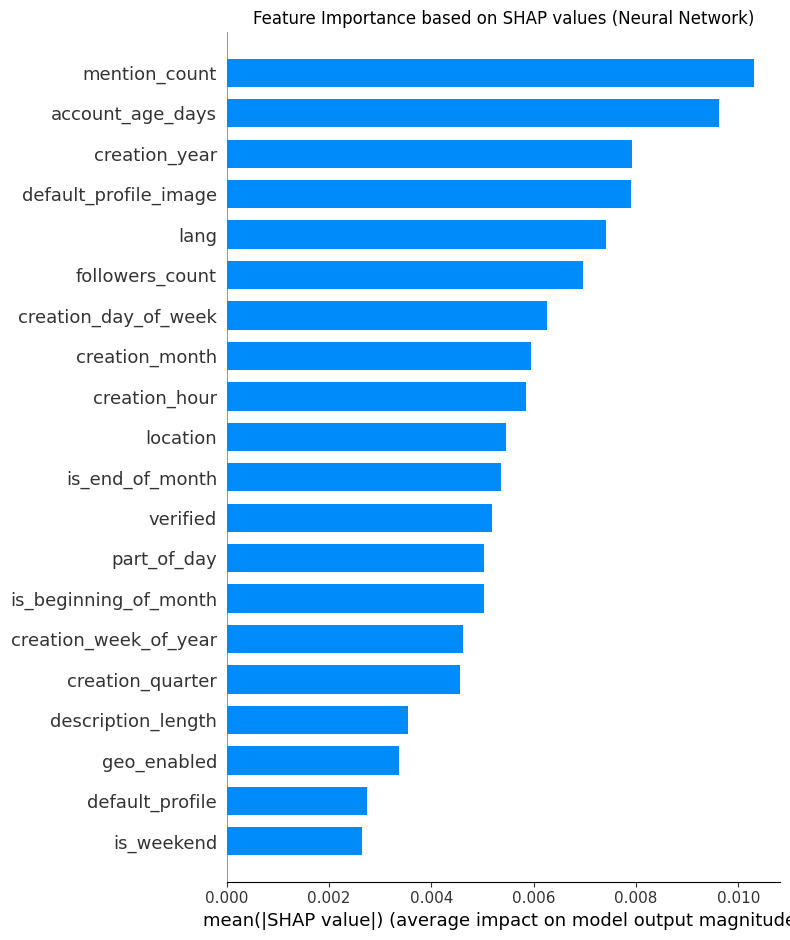


Feature Importance Ranking (Neural Network based):
                              feature  importance
26                      mention_count    0.010302
11                   account_age_days    0.009617
15                      creation_year    0.007929
1               default_profile_image    0.007898
6                                lang    0.007413
3                     followers_count    0.006967
13               creation_day_of_week    0.006267
14                     creation_month    0.005944
12                      creation_hour    0.005848
7                            location    0.005454
20                    is_end_of_month    0.005368
9                            verified    0.005186
21                        part_of_day    0.005033
19              is_beginning_of_month    0.005031
18              creation_week_of_year    0.004620
16                   creation_quarter    0.004561
23                 description_length    0.003537
5                         geo_enabled    0.00336

<Figure size 1200x800 with 0 Axes>

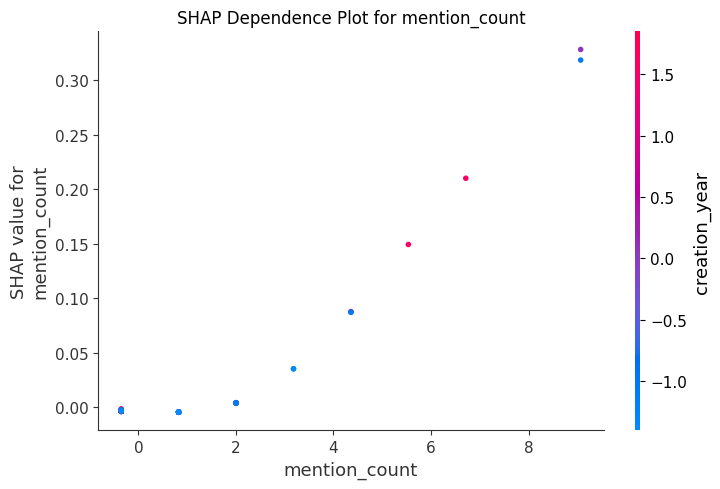

In [191]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import shap
import matplotlib.pyplot as plt

# Remove 'id' from feature list if present
features_no_id = [col for col in ae_cols if col.lower() != 'id']
X = mds[features_no_id].copy()

# Check for and handle any non-numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
if len(numeric_cols) != len(features_no_id):
    print(f"Warning: Found {len(features_no_id) - len(numeric_cols)} non-numeric columns")
    # Convert categorical variables if any
    X = pd.get_dummies(X, columns=[col for col in features_no_id if col not in numeric_cols])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
df['cluster'] = cluster_labels

# Identify small clusters as outliers
cluster_sizes = df['cluster'].value_counts()
small_clusters = cluster_sizes[cluster_sizes < (0.05 * len(df))].index
df['is_cluster_outlier'] = df['cluster'].apply(lambda x: 1 if x in small_clusters else 0)

# Build a more complex autoencoder for better feature learning
input_dim = X_scaled.shape[1]
encoding_dim = min(input_dim//2,14)

# Enhanced autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim * 4, activation='relu')(input_layer)
encoded = Dense(encoding_dim * 2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
decoded = Dense(encoding_dim * 4, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)  # We'll use this for SHAP analysis
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
normal_data = X_scaled[df['is_cluster_outlier'] == 0]
autoencoder.fit(
    normal_data, 
    normal_data,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    verbose=1
)

# Calculate reconstruction errors
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Mark autoencoder outliers
threshold = np.percentile(reconstruction_errors, 95)
df['is_autoencoder_outlier'] = (reconstruction_errors > threshold).astype(int)

# Combine outlier detection methods
df['is_outlier'] = np.where(
    (df['is_cluster_outlier'] == 1) | (df['is_autoencoder_outlier'] == 1),
    1, 0
)

# Function to predict outlier probability using autoencoder
def predict_outlier_probability(X_input):
    reconstructed = autoencoder.predict(X_input)
    errors = np.mean(np.square(X_input - reconstructed), axis=1)
    # Convert errors to probabilities using softmax-like normalization
    probs = 1 / (1 + np.exp(-errors))
    return probs

# Prepare background data for SHAP (using a subset for computational efficiency)
background_data = shap.sample(X_scaled_df, 100, random_state=42)

# Initialize KernelExplainer with our custom prediction function
explainer = shap.KernelExplainer(
    predict_outlier_probability,
    background_data
)

# Calculate SHAP values for a subset of data points
# Using a subset for demonstration, adjust the sample size based on your computational resources
n_samples = min(200, len(X_scaled_df))
sample_indices = np.random.choice(len(X_scaled_df), n_samples, replace=False)
sampled_data = X_scaled_df.iloc[sample_indices]

# Calculate SHAP values
shap_values = explainer.shap_values(sampled_data)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values, 
    sampled_data,
    feature_names=X.columns,
    plot_type="bar",
    show=False
)
plt.title("Feature Importance based on SHAP values (Neural Network)")
plt.tight_layout()
plt.show()

# Calculate and display feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nFeature Importance Ranking (Neural Network based):")
print(feature_importance)

# Print statistics
print("\nModel Statistics:")
print(f"Number of features analyzed: {len(X.columns)}")
print(f"Total samples: {len(df)}")
print(f"Number of outliers detected: {df['is_outlier'].sum()}")
print(f"Percentage of outliers: {(df['is_outlier'].sum() / len(df) * 100):.2f}%")

# Generate detailed SHAP analysis for top features
plt.figure(figsize=(12, 8))
shap.dependence_plot(
    feature_importance.iloc[0]['feature'],
    shap_values,
    sampled_data,
    show=False
)
plt.title(f"SHAP Dependence Plot for {feature_importance.iloc[0]['feature']}")
plt.tight_layout()
plt.show()

# Save feature importance to DataFrame

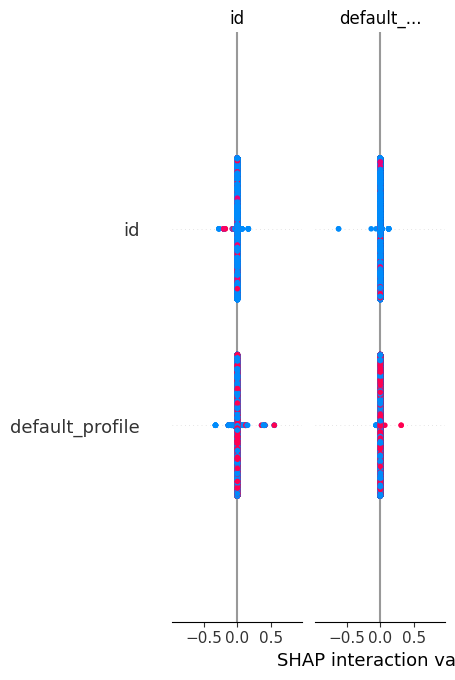

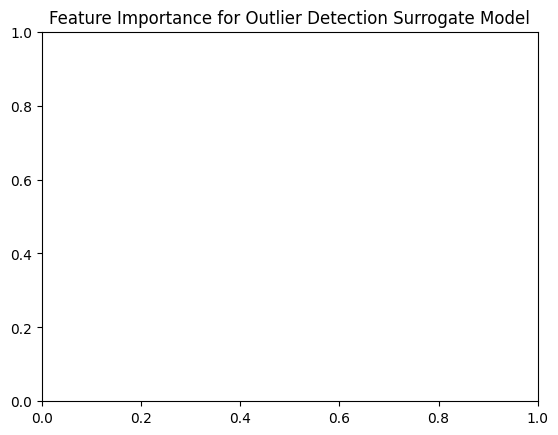

In [169]:
# Plot SHAP summary plot for feature importance
shap.summary_plot(shap_values, X_surrogate, plot_type="bar")
plt.title("Feature Importance for Outlier Detection Surrogate Model")
plt.show()